In [48]:
import pandas as pd 
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## 0. Loading & Processing Data

In [49]:
df = pd.read_csv(r".\NUS_IT\Train_Set.csv")
test_df = pd.read_csv(r".\NUS_IT\Test_Set.csv")
print(df.shape)
df.head()

(2193, 351)


,length_51,length_52,length_53,length_54,length_55,length_56,length_57,length_58,length_59,length_60,...,length_392,length_393,length_394,length_395,length_396,length_397,length_398,length_399,length_400,class_label
0,0.000152,0.000082,0.000087,0.000092,0.000099,0.000125,0.000122,0.000115,0.000151,0.000167,...,0.007396,0.007193,0.006973,0.006481,0.006139,0.005958,0.005578,0.005327,0.005142,healthy
1,0.006256,0.006413,0.006512,0.006469,0.006810,0.007070,0.007748,0.008088,0.008671,0.008835,...,0.017830,0.017033,0.016373,0.015371,0.014340,0.013975,0.013243,0.012725,0.012267,healthy
2,0.003783,0.003886,0.004063,0.004237,0.004481,0.004832,0.004960,0.005605,0.005919,0.006480,...,0.010957,0.010481,0.009782,0.009211,0.008800,0.008320,0.007869,0.007286,0.007020,healthy
3,0.004635,0.004471,0.004383,0.004829,0.004920,0.005056,0.005475,0.006158,0.007174,0.007697,...,0.010032,0.008933,0.008970,0.008546,0.008125,0.007587,0.007501,0.006931,0.006663,healthy
4,0.011315,0.010045,0.009795,0.009906,0.010630,0.011467,0.013024,0.014853,0.016874,0.017501,...,0.009118,0.008535,0.008233,0.007754,0.007584,0.006933,0.006530,0.006378,0.005842,healthy


In [50]:
df.columns[df.isna().sum()>0] # no columns that have 0 values (nice)

Index([], dtype='object')

In [51]:
cols_range=df.describe().loc['max']-df.describe().loc['min']
print(cols_range.min(),cols_range.max()) 
# smallest range in values of a single col is 0.0475, largest range in values of a single value is 0.937 
# --> disparity in ranges is present but nt very concerning + methods like DT & RF to be used >> more robust to diff in magnitudes/ scalars
# shld prob standardize

0.047518527000000005 0.936508562


In [52]:
df.dtypes.value_counts() # 350 columns with float dtypes (decimal type); 1 which is non-numeric (last one)

float64    350
object       1
dtype: int64

In [53]:
df['class_label'].value_counts() # mmmmmm, imbalanced dataset; ought to replicate/ SMOTE --> not too concerned w that

early stage cancer        781
screening stage cancer    490
mid stage cancer          453
late stage cancer         409
healthy                    60
Name: class_label, dtype: int64

In [54]:
dic={"healthy":1,"screening stage cancer":1,"early stage cancer":2,"mid stage cancer":3,"late stage cancer":4} 
# presumption is that screening stage is before early stage --> tho by right no true need to have this ranked necessarily + can modify easily
df['class_label'].map(dic).value_counts() # mapped appropriately

2    781
1    550
3    453
4    409
Name: class_label, dtype: int64

In [55]:
df['class_label'] = df['class_label'].map(dic) # changes the class_label column to numeric (ML model requires numeric data)
test_df['class_label'] = test_df['class_label'].map(dic) # likewise for the target

## 1. Splitting and Balancing Data

In [56]:
#### --> train test split first
r_state = 27 # for controlling of state 
target = "class_label"
X_cols=[i for i in df.columns if i!=target]
X_train,X_test,y_train,y_test= train_test_split(df[X_cols],df[target],test_size=0.35,stratify=df['class_label'],random_state = r_state)
df = pd.concat([X_train,y_train],axis=1)
dft = pd.concat([X_test,y_test],axis=1)

In [57]:
### to balance out target values (smote used on formatted data)

sm = SMOTE(random_state=r_state) # random state controlled to allow replication of results
target = 'class_label'
# may want to train test split FIRST before performing SMOTE all to protect data leakage --> results may nt be as good but hey
X_features = [i for i in df.columns if i!=target]
X,y = df[X_features], df[target]
X_res, y_res = sm.fit_resample(X, y)

In [58]:
df_SMOTE = pd.concat([X_res,y_res],axis=1)
df_SMOTE = df_SMOTE.sort_values(by="class_label")
df_SMOTE = df_SMOTE.reset_index().drop(columns=['index'])

In [59]:
df_SMOTE['class_label'].value_counts() # now balanced for all classes

1    508
2    508
3    508
4    508
Name: class_label, dtype: int64

In [60]:
# Replication of existing data 
def upsample(df):
        upsample_no = (abs(max(df['class_label'].value_counts())/df['class_label'].value_counts()-1) *\
                df['class_label'].value_counts()).apply(lambda x:int(x))
        # long code yes --> but basically looks at how many rows (roughly) for each label needs to be added 
        # such that all the labels are (roughly) balanced looks at existing data instead of synthetically generating new ones
        # --> variability does not increase BUT can be sure that repeats are actual data
        df_UP = df.copy()
        for i,e in upsample_no.items():
                df_UP = pd.concat([df_UP,(df[df['class_label']==i].sample(e,replace=True,random_state = r_state))],axis=0)
        return df_UP
df_UP = upsample(df)

In [61]:
df_UP = df_UP.sort_values(by="class_label")
df_UP = df_UP.reset_index().drop(columns=['index'])
df_UP['class_label'].value_counts() # similarly balanced dataset formed

1    508
2    508
4    508
3    507
Name: class_label, dtype: int64

In [62]:
len([r for i,r in df_SMOTE.iterrows() if (df_UP==r).all(1).any()]) # no. of shared rows between both SMOTE and UP (upsampled) datasets
# which is basically the size of the train dataset --> the rest that is added on is either synthetically generated (SMOTE) or replicated (UP)

1425

In [63]:
## SMOTE df used as the training df 
df = df_SMOTE

In [64]:
scaler = StandardScaler()
df[X_features] = scaler.fit_transform(df[X_features])

In [65]:
## will also upsample all instances of healthy class (such that model doesn't neglect that class)
# df = pd.concat([df,df[df['class_label']==0]],axis=0).reset_index().drop(columns=['index']) ## nt much of an impact

<Axes: >

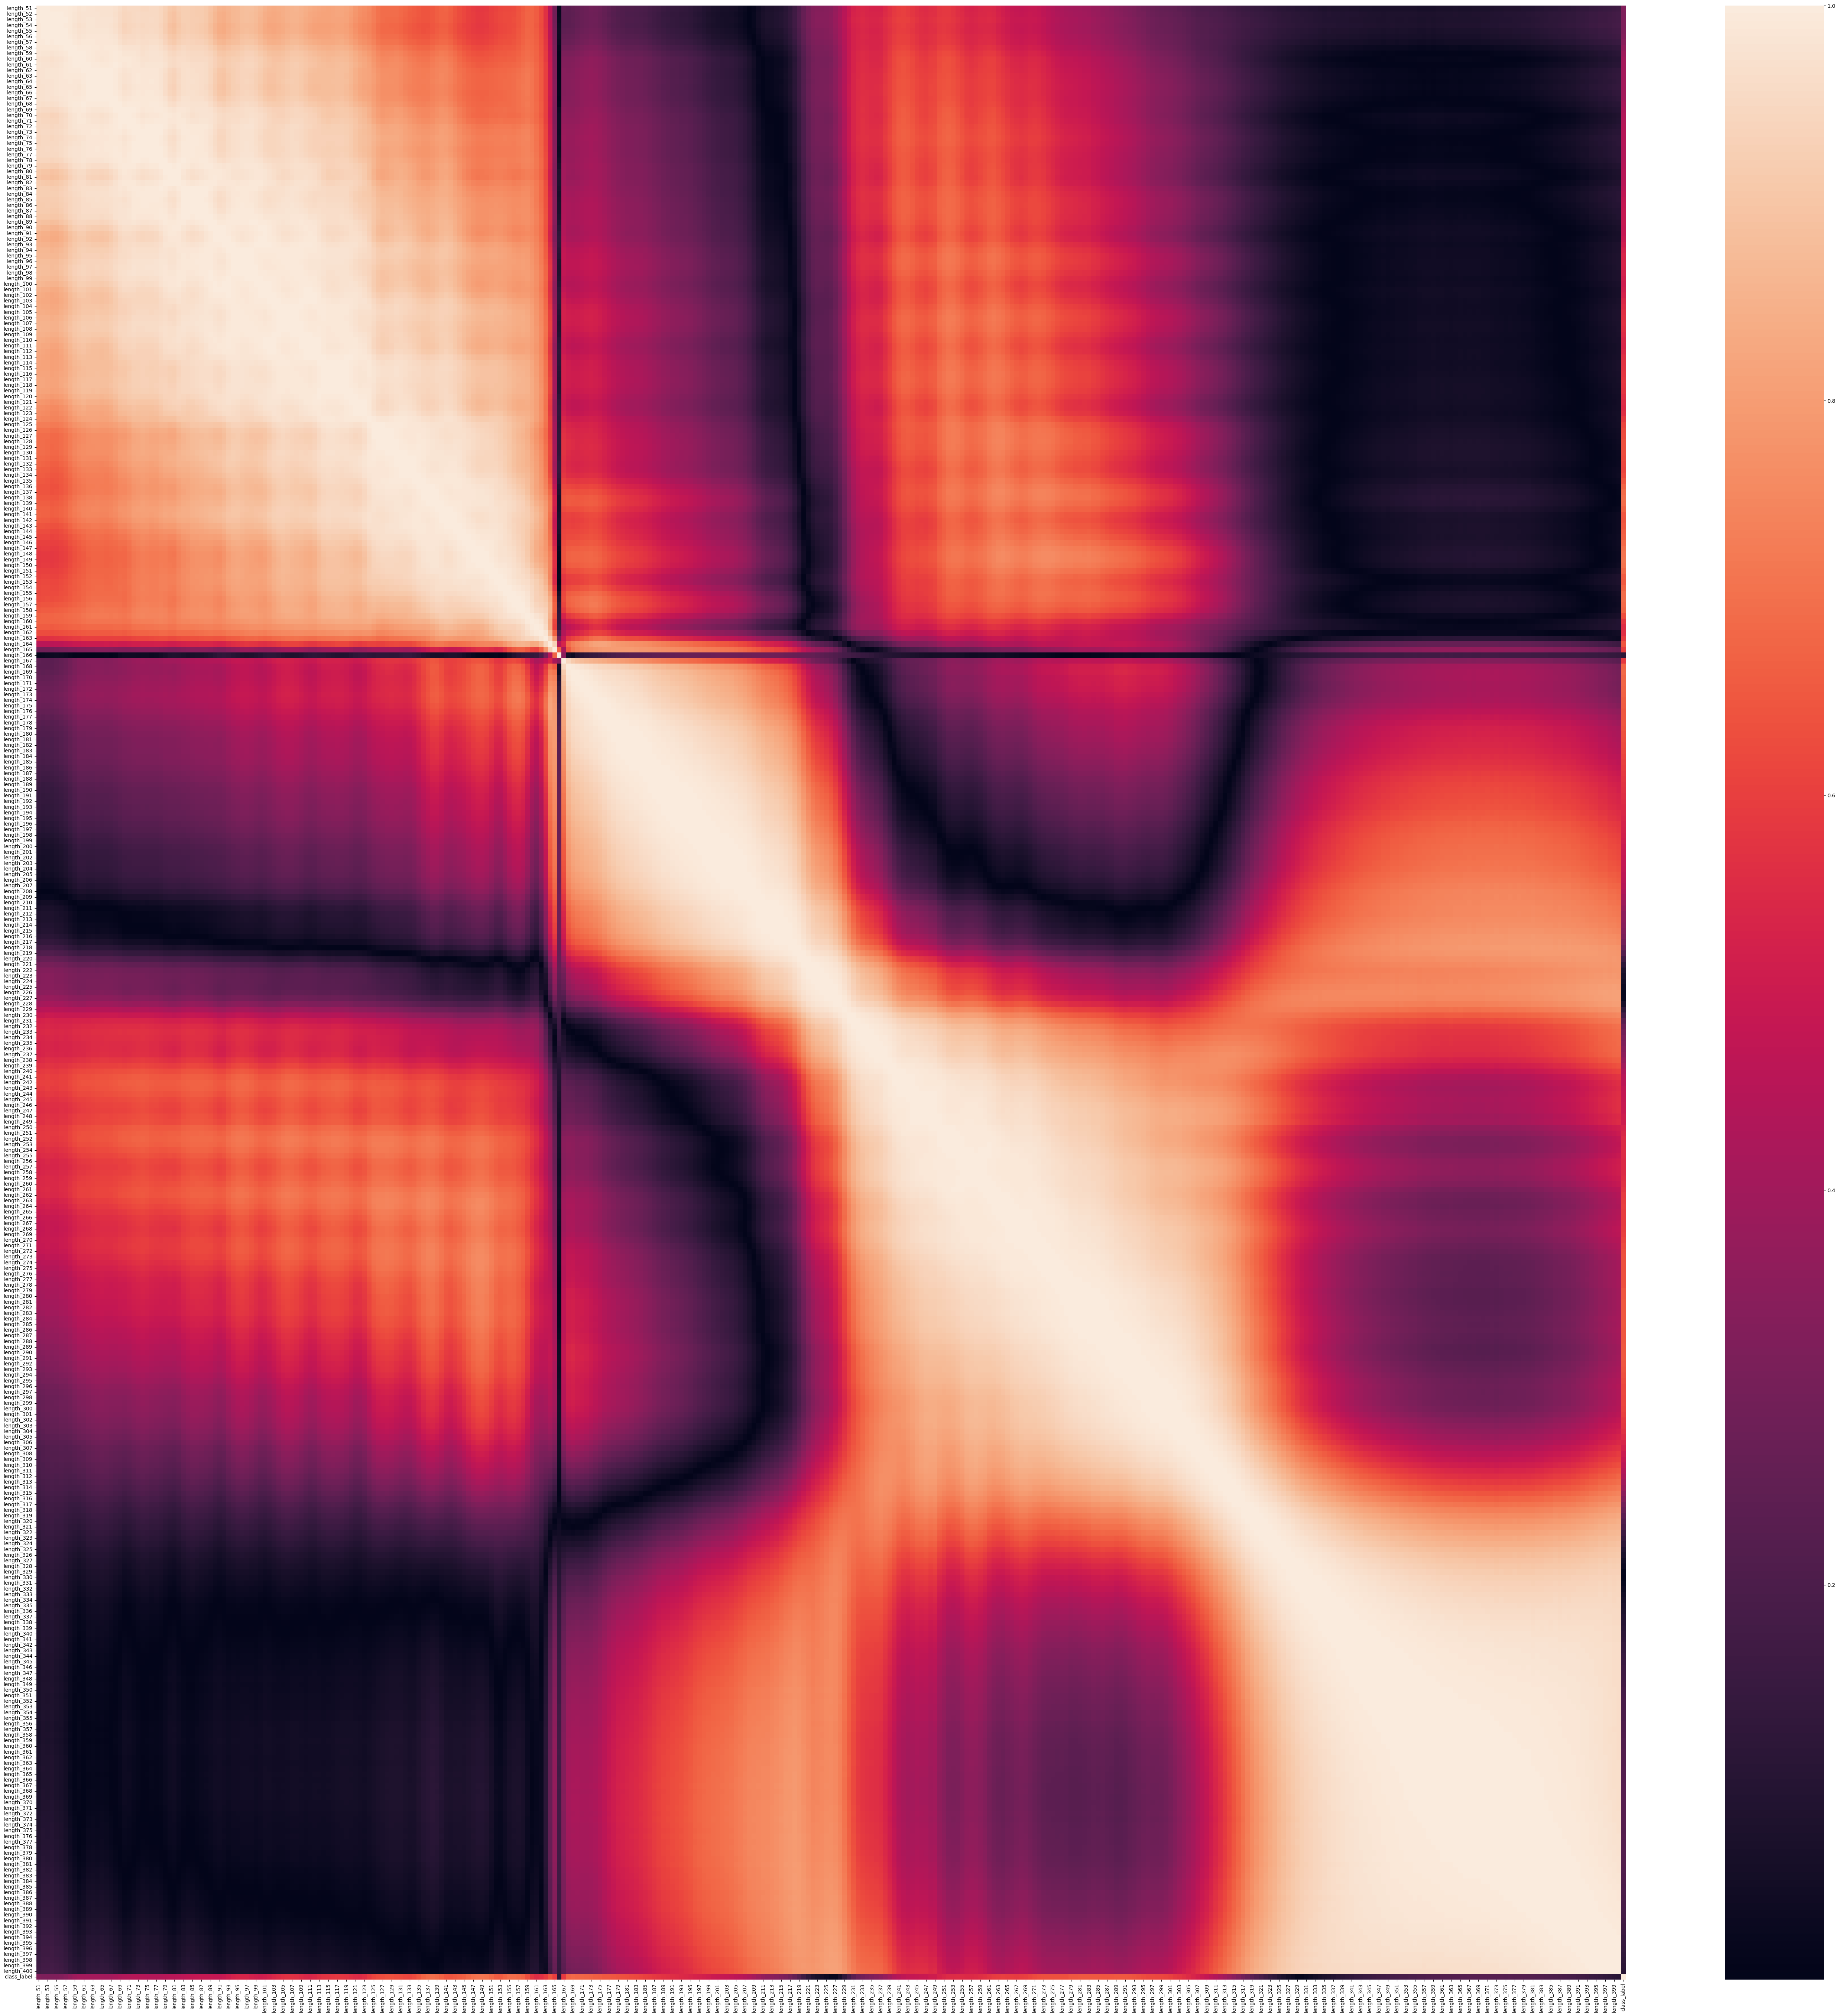

In [66]:
import seaborn as sns
f,ax = plt.subplots(figsize=(69, 69))
sns.heatmap(abs(df.corr()))

## 2. Identifying Important Features (Columns)

In [67]:
# corr matrix w the rest (to do)
# 130 - 160 
# 270 - 300

In [68]:
### Feature Ranking (based off SMOTE dataset)
## Using Random Forest to get important features <p decent speed>
model = RandomForestClassifier(random_state=r_state)
model.fit(df[X_cols], df[target])
sig_features = model.feature_importances_

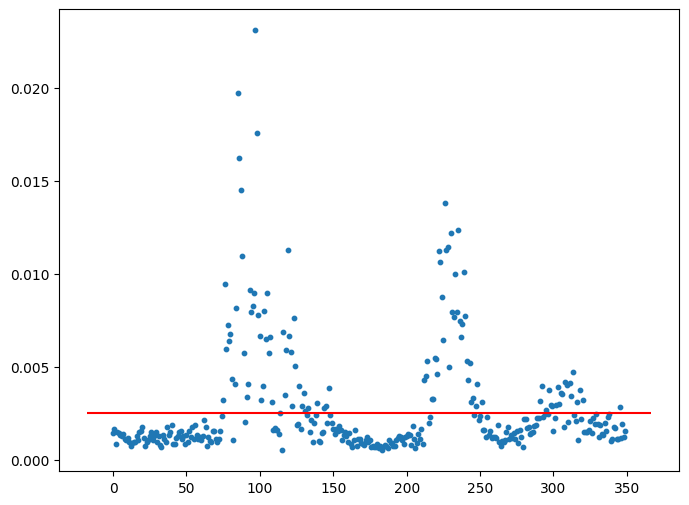

In [69]:
thresh = 0.00250# min-threshold at which feature is deemed significant (those above the red line in the plot)
plt.figure(figsize=(8,6))
plt.scatter(x=range(len(sig_features)),y=sig_features,s=10)
plt.hlines(thresh,xmin=plt.xlim()[0],xmax=plt.xlim()[1],color='red')
plt.show()

In [70]:

feature_scores = sorted([(i,e) for i,e in enumerate(sig_features) if e>thresh],key=lambda x:x[-1],reverse=True)
forest_features = df.columns[list(map(lambda x:x[0],feature_scores))]
forest_features # columns which are significant (based off tree-based RF importance)

Index(['length_148', 'length_136', 'length_149', 'length_137', 'length_138',
       'length_277', 'length_286', 'length_281', 'length_279', 'length_170',
       ...
       'length_350', 'length_180', 'length_196', 'length_298', 'length_396',
       'length_195', 'length_184', 'length_346', 'length_182', 'length_165'],
      dtype='object', length=106)

In [71]:
## Using SelectKBest to eliminate features with low F-score metrics in ANOVA <mb can remove since explanation nt exactly the easiest>
# <v fast>
n_features = len(forest_features)
skb = SelectKBest(f_classif, k=n_features)
X_new = skb.fit_transform(df[X_cols], df[target])
kbest_features = df.columns[skb.get_support(indices=True)]
print(kbest_features)
len(set(kbest_features).intersection(set(forest_features)))

Index(['length_114', 'length_115', 'length_116', 'length_117', 'length_118',
       'length_119', 'length_124', 'length_125', 'length_126', 'length_127',
       ...
       'length_292', 'length_293', 'length_294', 'length_295', 'length_296',
       'length_297', 'length_298', 'length_299', 'length_300', 'length_301'],
      dtype='object', length=106)


80

In [72]:
# Visualisations --> hmmmmmmmm
'''
focused_features = list(set(kbest_features).union(set(rfe_features).union(set(forest_features))))+[target]
dff = df[focused_features]
sns.pairplot(dff,hue=target) # ok wow pairplot does nt work well'''

'\nfocused_features = list(set(kbest_features).union(set(rfe_features).union(set(forest_features))))+[target]\ndff = df[focused_features]\nsns.pairplot(dff,hue=target) # ok wow pairplot does nt work well'

In [73]:
## Training Models


## for features >> will look at an overlap of all unique features identified by the different feature ranking methods 
thresh = 0.0025

feature_scores = sorted([(i,e) for i,e in enumerate(sig_features) if e>thresh],key=lambda x:x[-1],reverse=True)
forest_features = df.columns[list(map(lambda x:x[0],feature_scores))]
forest_features 

best_cols = list(forest_features)

## for features >> will look at INTERSECTING features identified by the different feature ranking methods 
#best_cols = list(set(kbest_features).intersection(set(forest_features).intersection(set(rfe_features))))
print(len(best_cols))
## will pass into different models and evaluate based off accuracy and precision

106


In [74]:
# Also will take a while as model is being trained
dt_clf  = DecisionTreeClassifier(random_state=r_state)
dt_clf.fit(df[best_cols],df[target])

rf_clf  = RandomForestClassifier(random_state=r_state)
rf_clf.fit(df[best_cols],df[target])

xgb_clf = GradientBoostingClassifier(random_state=r_state)
xgb_clf.fit(df[best_cols],df[target])

GradientBoostingClassifier(random_state=27)

In [75]:
dft[X_features] = scaler.transform(dft[X_features])

In [76]:
# predicted values based off each model type 
dt_pred  = dt_clf.predict(dft[best_cols]) # mb just use weights?

rf_pred  = rf_clf.predict(dft[best_cols])

xgb_pred = xgb_clf.predict(dft[best_cols])

In [77]:
# evaluation of each model's performance
print(f"Thresh: {thresh}\n")
reverse_lis = [k for k,v in sorted(dic.items(),key=lambda x:x[-1])]
reverse_lis = [reverse_lis[0]+'/'+reverse_lis[1]]+reverse_lis[2:]
print("Decision Tree Report:")
print(classification_report(dft[target],dt_pred,target_names = reverse_lis))
print("Random Forest Report:")
print(classification_report(dft[target],rf_pred,target_names = reverse_lis))
print("XGBoost Report:")
print(classification_report(dft[target],xgb_pred,target_names = reverse_lis))
## need to figure out a way to add weights to healthy + screening stages >> enhance their training performance
## hyperparameter tuning possibly

Thresh: 0.0025

Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.79      0.88      0.83       193
            early stage cancer       0.83      0.78      0.80       273
              mid stage cancer       0.72      0.73      0.73       159
             late stage cancer       0.88      0.84      0.86       143

                      accuracy                           0.80       768
                     macro avg       0.80      0.81      0.80       768
                  weighted avg       0.81      0.80      0.80       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.85      0.92      0.88       193
            early stage cancer       0.87      0.84      0.86       273
              mid stage cancer       0.79      0.82      0.80       159
             late stage cancer       0.93      0.85      0.89       143


In [78]:
'''

param_grid = { 
    'n_estimators': [40,50,80,100], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [2,3,5, 10, 20], 
    'max_leaf_nodes': [2,3, 5, 10], 
} 

grid_search = GridSearchCV(RandomForestClassifier(random_state=r_state), 
                           param_grid=param_grid) 
grid_search.fit(df[best_cols],df[target])

print(grid_search.best_params_)
'''

"\n\nparam_grid = { \n    'n_estimators': [40,50,80,100], \n    'max_features': ['sqrt', 'log2', None], \n    'max_depth': [2,3,5, 10, 20], \n    'max_leaf_nodes': [2,3, 5, 10], \n} \n\ngrid_search = GridSearchCV(RandomForestClassifier(random_state=r_state), \n                           param_grid=param_grid) \ngrid_search.fit(df[best_cols],df[target])\n\nprint(grid_search.best_params_)\n"

In [79]:
rf = RandomForestClassifier(random_state=r_state,max_depth = 10,max_features='sqrt',max_leaf_nodes=10,n_estimators=50)
rf.fit(df[best_cols],df[target]) 
y_pred = rf.predict(dft[best_cols])
print(classification_report(dft[target],y_pred,target_names = reverse_lis))

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.71      0.74      0.72       193
            early stage cancer       0.73      0.67      0.70       273
              mid stage cancer       0.62      0.74      0.67       159
             late stage cancer       0.88      0.80      0.84       143

                      accuracy                           0.72       768
                     macro avg       0.73      0.73      0.73       768
                  weighted avg       0.73      0.72      0.72       768



In [80]:
test_df[X_features] = scaler.transform(test_df[X_features])

In [81]:
print(classification_report(test_df[target],rf.predict(test_df[best_cols]),target_names = reverse_lis))

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.64      0.50      0.56       271
            early stage cancer       0.57      0.58      0.57       368
              mid stage cancer       0.54      0.74      0.63       206
             late stage cancer       0.90      0.79      0.85       189

                      accuracy                           0.63      1034
                     macro avg       0.66      0.65      0.65      1034
                  weighted avg       0.64      0.63      0.63      1034



In [82]:
#grid_search = GridSearchCV(GradientBoostingClassifier(random_state=r_state), param_grid=param_grid) 
#grid_search.fit(df[best_cols],df[target])
#print(grid_search.best_params_)

In [84]:
model_clf = RandomForestClassifier(random_state=r_state)
model_clf.fit(df[best_cols],df[target])
model_pred = model_clf.predict(test_df[best_cols])
print(classification_report(test_df[target],model_pred,target_names = reverse_lis))

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.73      0.59      0.65       271
            early stage cancer       0.65      0.70      0.67       368
              mid stage cancer       0.59      0.73      0.65       206
             late stage cancer       0.89      0.79      0.83       189

                      accuracy                           0.69      1034
                     macro avg       0.71      0.70      0.70      1034
                  weighted avg       0.70      0.69      0.69      1034



In [85]:
dff = pd.concat([df,dft])

In [86]:
dff[X_features] = scaler.fit_transform(dff[X_features])
test_df[X_features] = scaler.transform(test_df[X_features])

In [87]:
rf_clf = RandomForestClassifier(random_state=r_state)
rf_clf.fit(dff[best_cols],dff[target])
p = rf_clf.predict(test_df[best_cols])

In [88]:
print(classification_report(test_df[target],p,target_names = reverse_lis))

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.76      0.57      0.65       271
            early stage cancer       0.64      0.70      0.66       368
              mid stage cancer       0.61      0.75      0.67       206
             late stage cancer       0.87      0.81      0.84       189

                      accuracy                           0.69      1034
                     macro avg       0.72      0.71      0.71      1034
                  weighted avg       0.71      0.69      0.69      1034



In [89]:
def upsample(df):
        upsample_no = (abs(max(df['class_label'].value_counts())/df['class_label'].value_counts()-1) *\
                df['class_label'].value_counts()).apply(lambda x:int(x))
        # long code yes --> but basically looks at how many rows (roughly) for each label needs to be added 
        # such that all the labels are (roughly) balanced looks at existing data instead of synthetically generating new ones
        # --> variability does not increase BUT can be sure that repeats are actual data
        df_UP = df.copy()
        for i,e in upsample_no.items():
                df_UP = pd.concat([df_UP,(df[df['class_label']==i].sample(e,replace=True,random_state = r_state))],axis=0)
        return df_UP

dft_UP = upsample(dft)
train_df = pd.concat([df,dft_UP],axis=0).reset_index().drop(columns=['index'])